<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Cooler-command-line-interface" data-toc-modified-id="Cooler-command-line-interface-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cooler command line interface</a></span><ul class="toc-item"><li><span><a href="#Example" data-toc-modified-id="Example-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Example</a></span></li><li><span><a href="#Aggregate-a-list-of-read-pairs-into-a-cool-file" data-toc-modified-id="Aggregate-a-list-of-read-pairs-into-a-cool-file-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Aggregate a list of read pairs into a <code>cool</code> file</a></span></li><li><span><a href="#Text-export" data-toc-modified-id="Text-export-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Text export</a></span></li><li><span><a href="#Balancing" data-toc-modified-id="Balancing-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Balancing</a></span></li><li><span><a href="#Display-the-contact-matrix" data-toc-modified-id="Display-the-contact-matrix-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Display the contact matrix</a></span></li><li><span><a href="#Optional:-Load-a-pairs-file-indexed-with-Pairix" data-toc-modified-id="Optional:-Load-a-pairs-file-indexed-with-Pairix-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Optional: Load a pairs file indexed with <a href="https://github.com/4dn-dcic/pairix" target="_blank">Pairix</a></a></span></li></ul></li></ul></div>

Notes:

To simulate shell scripts and terminal interaction, we preface every code cell with the "cell magic": `%%bash`, which sends the code to bash instead of the Python interpreter. Another way to send code from IPython to the shell is to prefix a line with shell escape `!`.

# Cooler command line interface

If you type `cooler` at the command line with no arguments or with `-h` or `--help` you'll get the following quick reference of available subcommands.

In [1]:
%%bash

cooler -h

Usage: cooler [OPTIONS] COMMAND [ARGS]...

  Type -h or --help after any subcommand for more information.

Options:
  -v, --verbose  Verbose logging.
  -d, --debug    On error, drop into the post-mortem debugger shell.
  -V, --version  Show the version and exit.
  -h, --help     Show this message and exit.

Commands:
  cload     Create a cooler from genomic pairs and bins.
  load      Create a cooler from a pre-binned matrix.
  merge     Merge multiple coolers with identical axes.
  coarsen   Coarsen a cooler to a lower resolution.
  zoomify   Generate a multi-resolution cooler file by coarsening.
  balance   Out-of-core matrix balancing.
  info      Display a cooler's info and metadata.
  dump      Dump a cooler's data to a text stream.
  show      Display and browse a cooler in matplotlib.
  makebins  Generate fixed-width genomic bins.
  digest    Generate fragment-delimited genomic bins.
  csort     Sort and index a contact list.
  ls        List all coolers inside a file.
  cp     

For more information about a specific subcommand, type `cooler <subcommand> -h` to display the help text.

In [2]:
%%bash

cooler info -h

Usage: cooler info [OPTIONS] COOL_PATH

  Display a cooler's info and metadata.

  COOL_PATH : Path to a COOL file or cooler URI.

Options:
  -f, --field TEXT  Print the value of a specific info field.
  -m, --metadata    Print the user metadata in JSON format.
  -o, --out TEXT    Output file (defaults to stdout)
  -h, --help        Show this message and exit.


## Example

Let's try it.

In [3]:
%%bash

cooler info data/Rao2014-GM12878-MboI-allreps-filtered.1000kb.cool

{
    "bin-size": 1000000,
    "bin-type": "fixed",
    "creation-date": "2016-02-25T21:05:29.075865",
    "format-url": "https://github.com/mirnylab/cooler",
    "format-version": 2,
    "genome-assembly": "hg19",
    "id": null,
    "library-version": "0.3.0",
    "nbins": 3114,
    "nchroms": 25,
    "nnz": 4150156
}


In [4]:
%%bash

cooler info -f bin-size data/Rao2014-GM12878-MboI-allreps-filtered.1000kb.cool

1000000


In [5]:
%%bash

cooler info -m data/Rao2014-GM12878-MboI-allreps-filtered.1000kb.cool

{
    "publication": "",
    "QC": {
        "double-sided": {
            "total": 3390352656,
            "valid": 3147639590,
            "filtered-invalid": {
                "removed-self-circles": 1741768,
                "removed-error-pair": 6074295,
                "removed-dangling-ends": 234897003
            },
            "filtered-valid": {
                "removed-duplicate": 110650005,
                "removed-start-near-rsite": "",
                "removed-outlier-fragment": 151337031,
                "removed-large-small-pair": 657466
            }
        },
        "pre-filtering": {
            "total": 5332721651,
            "double-sided": 3390352656,
            "unused": 0,
            "single-sided": 1942368995
        },
        "post-filtering": {
            "total": 2884995088,
            "cis": 2085711027,
            "trans": 799284061
        }
    },
    "enzyme": "MboI",
    "cell-type": "GM12878",
    "species": "Homo sapiens",
    "sex": "F"
}


## Aggregate a list of read pairs into a `cool` file

To make a contact matrix, we need

1. A list of read pairs representing captured contacts.
2. A segmentation of the genome into bins by which we aggregate (bin) the read pair counts.

For(1), we will start with a very small subsample of 100,000 read pairs from GSM1551552 (Rao et al, GM12878). The fields of the file are readID, strand1, chrom1, pos1, frag1, strand2, chrom2, pos2, frag2, mapq1, mapq2.

In [6]:
%%bash

zcat data/GSM1551552_HIC003_merged_nodups.txt.subset.gz | head

D260LACXX130602:2:2315:7361:72358 0 1 85378 186 16 1 591085 1097 0 0
D258GACXX130605:8:2316:2958:10584 0 1 728403 1418 16 1 719104 1406 20 10
C24LCACXX130513:8:2315:5697:82732 0 1 758309 1523 0 1 43498676 121266 68 120
D260LACXX130602:2:2202:16754:100485 16 1 890311 1801 16 1 993887 2056 165 18
D260LACXX130602:2:2309:8547:48542 0 1 925938 1866 16 1 1034493 2117 178 60
C24LCACXX130513:8:2312:14225:27548 0 1 941657 1904 0 1 1620964 3551 178 0
D258GACXX130605:8:2308:5276:50416 0 1 992230 2049 0 1 1255504 2556 175 178
C24LCACXX130513:8:1308:7340:36704 0 1 1070613 2191 16 1 1070941 2193 153 40
C24LCACXX130513:8:2104:5074:54778 16 1 1137145 2329 16 1 201625081 455535 144 178
C24LCACXX130513:8:1302:14464:56521 0 1 1170252 2381 16 1 1353433 2788 178 22


This data was mapped to the Broad's `b37` assembly and uses ENSEMBL-style chromosome names (`1..22`, `X`, `Y`, `MT`) instead of the UCSC-style (`chr1..chr22`, `chrX`, `chrY`, `chrM`).

We provide a chromosome sizes file with the chromosomes we want to use in a desired order. Make sure the name style of the chromsizes file matches the name style of the pairs file! The following is the `b37` chromosome sizes file with chromosomes in a "natural" semantic order, leaving out the unlocalized and unplaced scaffolds.

In [7]:
%%bash

cat data/b37.chrom.sizes

1	249250621
2	243199373
3	198022430
4	191154276
5	180915260
6	171115067
7	159138663
8	146364022
9	141213431
10	135534747
11	135006516
12	133851895
13	115169878
14	107349540
15	102531392
16	90354753
17	81195210
18	78077248
19	59128983
20	63025520
21	48129895
22	51304566
X	155270560
Y	59373566
MT	16569


We also need to decide how we want to bin the contacts. Usually, we choose a fixed bin size or "resolution". Another option for Hi-C data is to use restriction fragment-delimited genomic bins based on the restriction enzyme used in the experiment. `cooler` allows for any binning scheme you like, as long as you provide it as a **bin table**. We can store a bin table in a simple BED file using the `makebins` command.

In [8]:
%%bash

cooler makebins -h

Usage: cooler makebins [OPTIONS] CHROMSIZES_PATH BINSIZE

  Generate fixed-width genomic bins.

  Output a genome segmentation at a fixed resolution as a BED file.

  CHROMSIZES_PATH : UCSC-like chromsizes file, with chromosomes in desired
  order.

  BINSIZE : Resolution (bin size) in base pairs <int>.

Options:
  -o, --out TEXT       Output file (defaults to stdout)
  -H, --header         Print the header of column names as the first row.
                       [default: False]
  -i, --rel-ids [0|1]  Include a column of relative bin IDs for each
                       chromosome. Choose whether to report them as 0- or
                       1-based.
  -h, --help           Show this message and exit.


If you have the FASTA sequence of the reference genome, you can also "digest" it to create a bin table of fragments.

In [9]:
%%bash

cooler digest -h

Usage: cooler digest [OPTIONS] CHROMSIZES_PATH FASTA_PATH ENZYME

  Generate fragment-delimited genomic bins.

  Output a genome segmentation of restriction fragments as a BED file.

  CHROMSIZES_PATH : UCSC-like chromsizes file, with chromosomes in desired
  order.

  FASTA_PATH : Genome assembly FASTA file or folder containing FASTA files
  (uncompressed).

  ENZYME : Name of restriction enzyme

Options:
  -o, --out TEXT       Output file (defaults to stdout)
  -H, --header         Print the header of column names as the first row.
                       [default: False]
  -i, --rel-ids [0|1]  Include a column of relative bin IDs for each
                       chromosome. Choose whether to report them as 0- or
                       1-based.
  -h, --help           Show this message and exit.


In [10]:
%%bash

CHROMSIZES_FILE='data/b37.chrom.sizes'

cooler makebins --out bins.1000kb.bed $CHROMSIZES_FILE 1000000

# what's in the file?
head bins.1000kb.bed

1	0	1000000
1	1000000	2000000
1	2000000	3000000
1	3000000	4000000
1	4000000	5000000
1	5000000	6000000
1	6000000	7000000
1	7000000	8000000
1	8000000	9000000
1	9000000	10000000


Note that there is a convenient syntax to specify a fixed-resolution bin table, so you rarely need to generate one manually: 

```
<chromsizes_path>:<binsize-in-bp>
```

e.g. The bin table above can be specified as `data/b37.chrom.sizes.reduced:1000000`.

In [11]:
%%bash

cooler cload pairs -h

Usage: cooler cload pairs [OPTIONS] BINS PAIRS_PATH COOL_PATH

  Bin any text file or stream of pairs.

  Pairs data need not be sorted. Accepts compressed files. To pipe input
  from stdin, set PAIRS_PATH to '-'.

  BINS : One of the following

      <TEXT:INTEGER> : 1. Path to a chromsizes file, 2. Bin size in bp

      <TEXT> : Path to BED file defining the genomic bin segmentation.

  PAIRS_PATH : Path to contacts (i.e. read pairs) file.

  COOL_PATH : Output COOL file path or URI.

Options:
  --metadata TEXT                 Path to JSON file containing user metadata.
  --assembly TEXT                 Name of genome assembly (e.g. hg19, mm10)
  -c1, --chrom1 INTEGER           chrom1 field number (one-based)  [required]
  -p1, --pos1 INTEGER             pos1 field number (one-based)  [required]
  -c2, --chrom2 INTEGER           chrom2 field number (one-based)  [required]
  -p2, --pos2 INTEGER             pos2 field number (one-based)  [required]
  --chunksize INTEGER             Num

In [12]:
%%bash
# Note that the input pairs file happens to be space-delimited, so we convert to tab-delimited with `tr`.
CHROMSIZES_FILE='data/b37.chrom.sizes'
BINSIZE=1000000
PAIRS_FILE='data/GSM1551552_HIC003_merged_nodups.txt.subset.gz'
OUTPUT_FILE='test.cool'

zcat $PAIRS_FILE \
    | tr ' ' '\t' \
    | cooler cload pairs -c1 3 -p1 4 -c2 7 -p2 8 $CHROMSIZES_FILE:$BINSIZE - $OUTPUT_FILE 

INFO:cooler.create:Writing chunk 0: /tmp/tmpsb_ijxnw.multi.cool::0
INFO:cooler.create:Creating cooler at "/tmp/tmpsb_ijxnw.multi.cool::/0"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Done
INFO:cooler.create:Merging into test.cool
INFO:cooler.create:Creating cooler at "test.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.reduce:nnzs: [46598]
INFO:cooler.reduce:current: [46598]
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Done


There are benefits to sorting and indexing pairs. See below.

## Text export

The `cooler dump` command lets us print the data back out as text with several formatting and annotation options. It also accepts range queries, both intra- and inter-chromosomal.

In [13]:
%%bash

cooler dump -h

Usage: cooler dump [OPTIONS] COOL_PATH

  Dump a cooler's data to a text stream.

  COOL_PATH : Path to COOL file or cooler URI.

Options:
  -t, --table [chroms|bins|pixels]
                                  Which table to dump. Choosing 'chroms' or
                                  'bins' will cause all pixel-related options
                                  to be ignored. Note that for coolers stored
                                  in symmetric-upper mode, 'pixels' only holds
                                  the upper triangle values of the matrix.
                                  [default: pixels]
  -c, --columns SEPARATED[,]      Restrict output to a subset of columns,
                                  provided as a comma-separated list.
  -H, --header                    Print the header of column names as the
                                  first row.  [default: False]
  --na-rep TEXT                   Missing data representation. Default is
                                 

In [14]:
%%bash

cooler dump -t chroms test.cool

1	249250621
2	243199373
3	198022430
4	191154276
5	180915260
6	171115067
7	159138663
8	146364022
9	141213431
10	135534747
11	135006516
12	133851895
13	115169878
14	107349540
15	102531392
16	90354753
17	81195210
18	78077248
19	59128983
20	63025520
21	48129895
22	51304566
X	155270560
Y	59373566
MT	16569


In [15]:
%%bash

cooler dump -t bins test.cool | head

1	0	1000000
1	1000000	2000000
1	2000000	3000000
1	3000000	4000000
1	4000000	5000000
1	5000000	6000000
1	6000000	7000000
1	7000000	8000000
1	8000000	9000000
1	9000000	10000000


In [16]:
%%bash

cooler dump -t pixels --header test.cool | head

bin1_id	bin2_id	count
0	0	3
0	1	4
0	43	1
0	155	1
0	229	1
0	437	1
0	492	1
0	493	1
0	666	1


In [17]:
%%bash

cooler dump -t pixels --header --join test.cool | head

chrom1	start1	end1	chrom2	start2	end2	count
1	0	1000000	1	0	1000000	3
1	0	1000000	1	1000000	2000000	4
1	0	1000000	1	43000000	44000000	1
1	0	1000000	1	155000000	156000000	1
1	0	1000000	1	229000000	230000000	1
1	0	1000000	2	187000000	188000000	1
1	0	1000000	2	242000000	243000000	1
1	0	1000000	2	243000000	243199373	1
1	0	1000000	3	172000000	173000000	1


In [18]:
%%bash

cooler dump -t pixels -r 10:10,000,000-20,000,000 -r2 10:30,000,000-80,000,000 --header --join test.cool | head

chrom1	start1	end1	chrom2	start2	end2	count
10	10000000	11000000	10	70000000	71000000	1
10	11000000	12000000	10	30000000	31000000	1
10	11000000	12000000	10	35000000	36000000	1
10	11000000	12000000	10	42000000	43000000	2
10	11000000	12000000	10	43000000	44000000	1
10	11000000	12000000	10	52000000	53000000	1
10	11000000	12000000	10	58000000	59000000	1
10	12000000	13000000	10	30000000	31000000	1
10	12000000	13000000	10	45000000	46000000	1


In [19]:
%%bash

cooler dump -t pixels --header --balanced test.cool | head

Balancing weights not found


Oops! Our contact matrix isn't balanced yet. Let's do that next.

## Balancing

Matrix balancing normalization, i.e. iterative correction.

We usually normalize or "correct" Hi-C using a technique called matrix balancing. This involves finding a set of weights or biases $b_i$ for each bin $i$ such that

$$ Normalized[i,j] = Observed[i,j] \cdot b[i] \cdot b[j], $$

such that the marginals (i.e., row/column sums) of the global contact matrix are flat and equal.

`cooler balance` will store the pre-computed balancing weights in the bin table as an extra column called `weight`.

Note that whole-genome matrix balancing on a high resolution matrix requires iterative computations on a matrix that may not fit in computer memory, even in sparse form. Our "out-of-core" method performs the calculations by splitting and loading the data into smaller chunks and combining the partial results afterwards.

In [20]:
%%bash

cooler balance -h

Usage: cooler balance [OPTIONS] COOL_PATH

  Out-of-core matrix balancing.

  Matrix must be symmetric. See the help for various filtering options to
  mask out poorly mapped bins.

  COOL_PATH : Path to a COOL file.

Options:
  -p, --nproc INTEGER             Number of processes to split the work
                                  between.  [default: 8]
  -c, --chunksize INTEGER         Control the number of pixels handled by each
                                  worker process at a time.  [default:
                                  10000000]
  --mad-max INTEGER               Ignore bins from the contact matrix using
                                  the 'MAD-max' filter: bins whose log
                                  marginal sum is less than ``mad-max`` median
                                  absolute deviations below the median log
                                  marginal sum of all the bins in the same
                                  chromosome.  [default: 5]
  --min-nnz IN

`cooler balance` iterates until the balanced marginals (i.e. row sums of the balanced matrix) are sufficiently flat (the variance falls below the limit `tol`).

In [21]:
%%bash

cooler balance -p 10 -c 10000 test.cool

INFO:cooler.cli.balance:Balancing "test.cool"
INFO:cooler.balance:variance is 108.70508940352958
INFO:cooler.balance:variance is 11.544325707535195
INFO:cooler.balance:variance is 2.6406181035180114
INFO:cooler.balance:variance is 0.7820569377009836
INFO:cooler.balance:variance is 0.24307866485487492
INFO:cooler.balance:variance is 0.08214976966884287
INFO:cooler.balance:variance is 0.028125223955516684
INFO:cooler.balance:variance is 0.010077907090866369
INFO:cooler.balance:variance is 0.0036415810798656125
INFO:cooler.balance:variance is 0.0013517640780139238
INFO:cooler.balance:variance is 0.0005055339361931204
INFO:cooler.balance:variance is 0.00019213135598238152
INFO:cooler.balance:variance is 7.348487864297223e-05
INFO:cooler.balance:variance is 2.8383812188298613e-05
INFO:cooler.balance:variance is 1.1018544001828532e-05
INFO:cooler.balance:variance is 4.304041056889207e-06


In [22]:
%%bash

cooler dump --header --balanced test.cool | head

bin1_id	bin2_id	count	balanced
0	0	3	0.0619576
0	1	4	0.0917378
0	43	1	0.0246198
0	155	1	0.0223535
0	229	1	0.0292275
0	437	1	0.0364777
0	492	1	0.0238998
0	493	1	0.0843047
0	666	1	0.023308


## Display the contact matrix

You can also use the `cooler show` function to produce images of the contact matrix. Requires the `matplotlib` Python package.

In [23]:
%%bash

cooler show -h

Usage: cooler show [OPTIONS] COOL_PATH RANGE

  Display and browse a cooler in matplotlib.

  COOL_PATH : Path to a COOL file or Cooler URI.

  RANGE : The coordinates of the genomic region to display, in UCSC
  notation. Example: chr1:10,000,000-11,000,000

Options:
  -r2, --range2 TEXT              The coordinates of a genomic region shown
                                  along the column dimension. If omitted, the
                                  column range is the same as the row range.
                                  Use to display asymmetric matrices or trans
                                  interactions.
  -b, --balanced                  Show the balanced contact matrix. If not
                                  provided, display the unbalanced counts.
  -o, --out TEXT                  Save the image of the contact matrix to a
                                  file. If not specified, the matrix is
                                  displayed in an interactive window. The
   

Here's the undersampled dataset.

In [24]:
%%bash

cooler show --out test.png --dpi 200 test.cool 3:0-80,000,000

  mat = np.log10(mat)



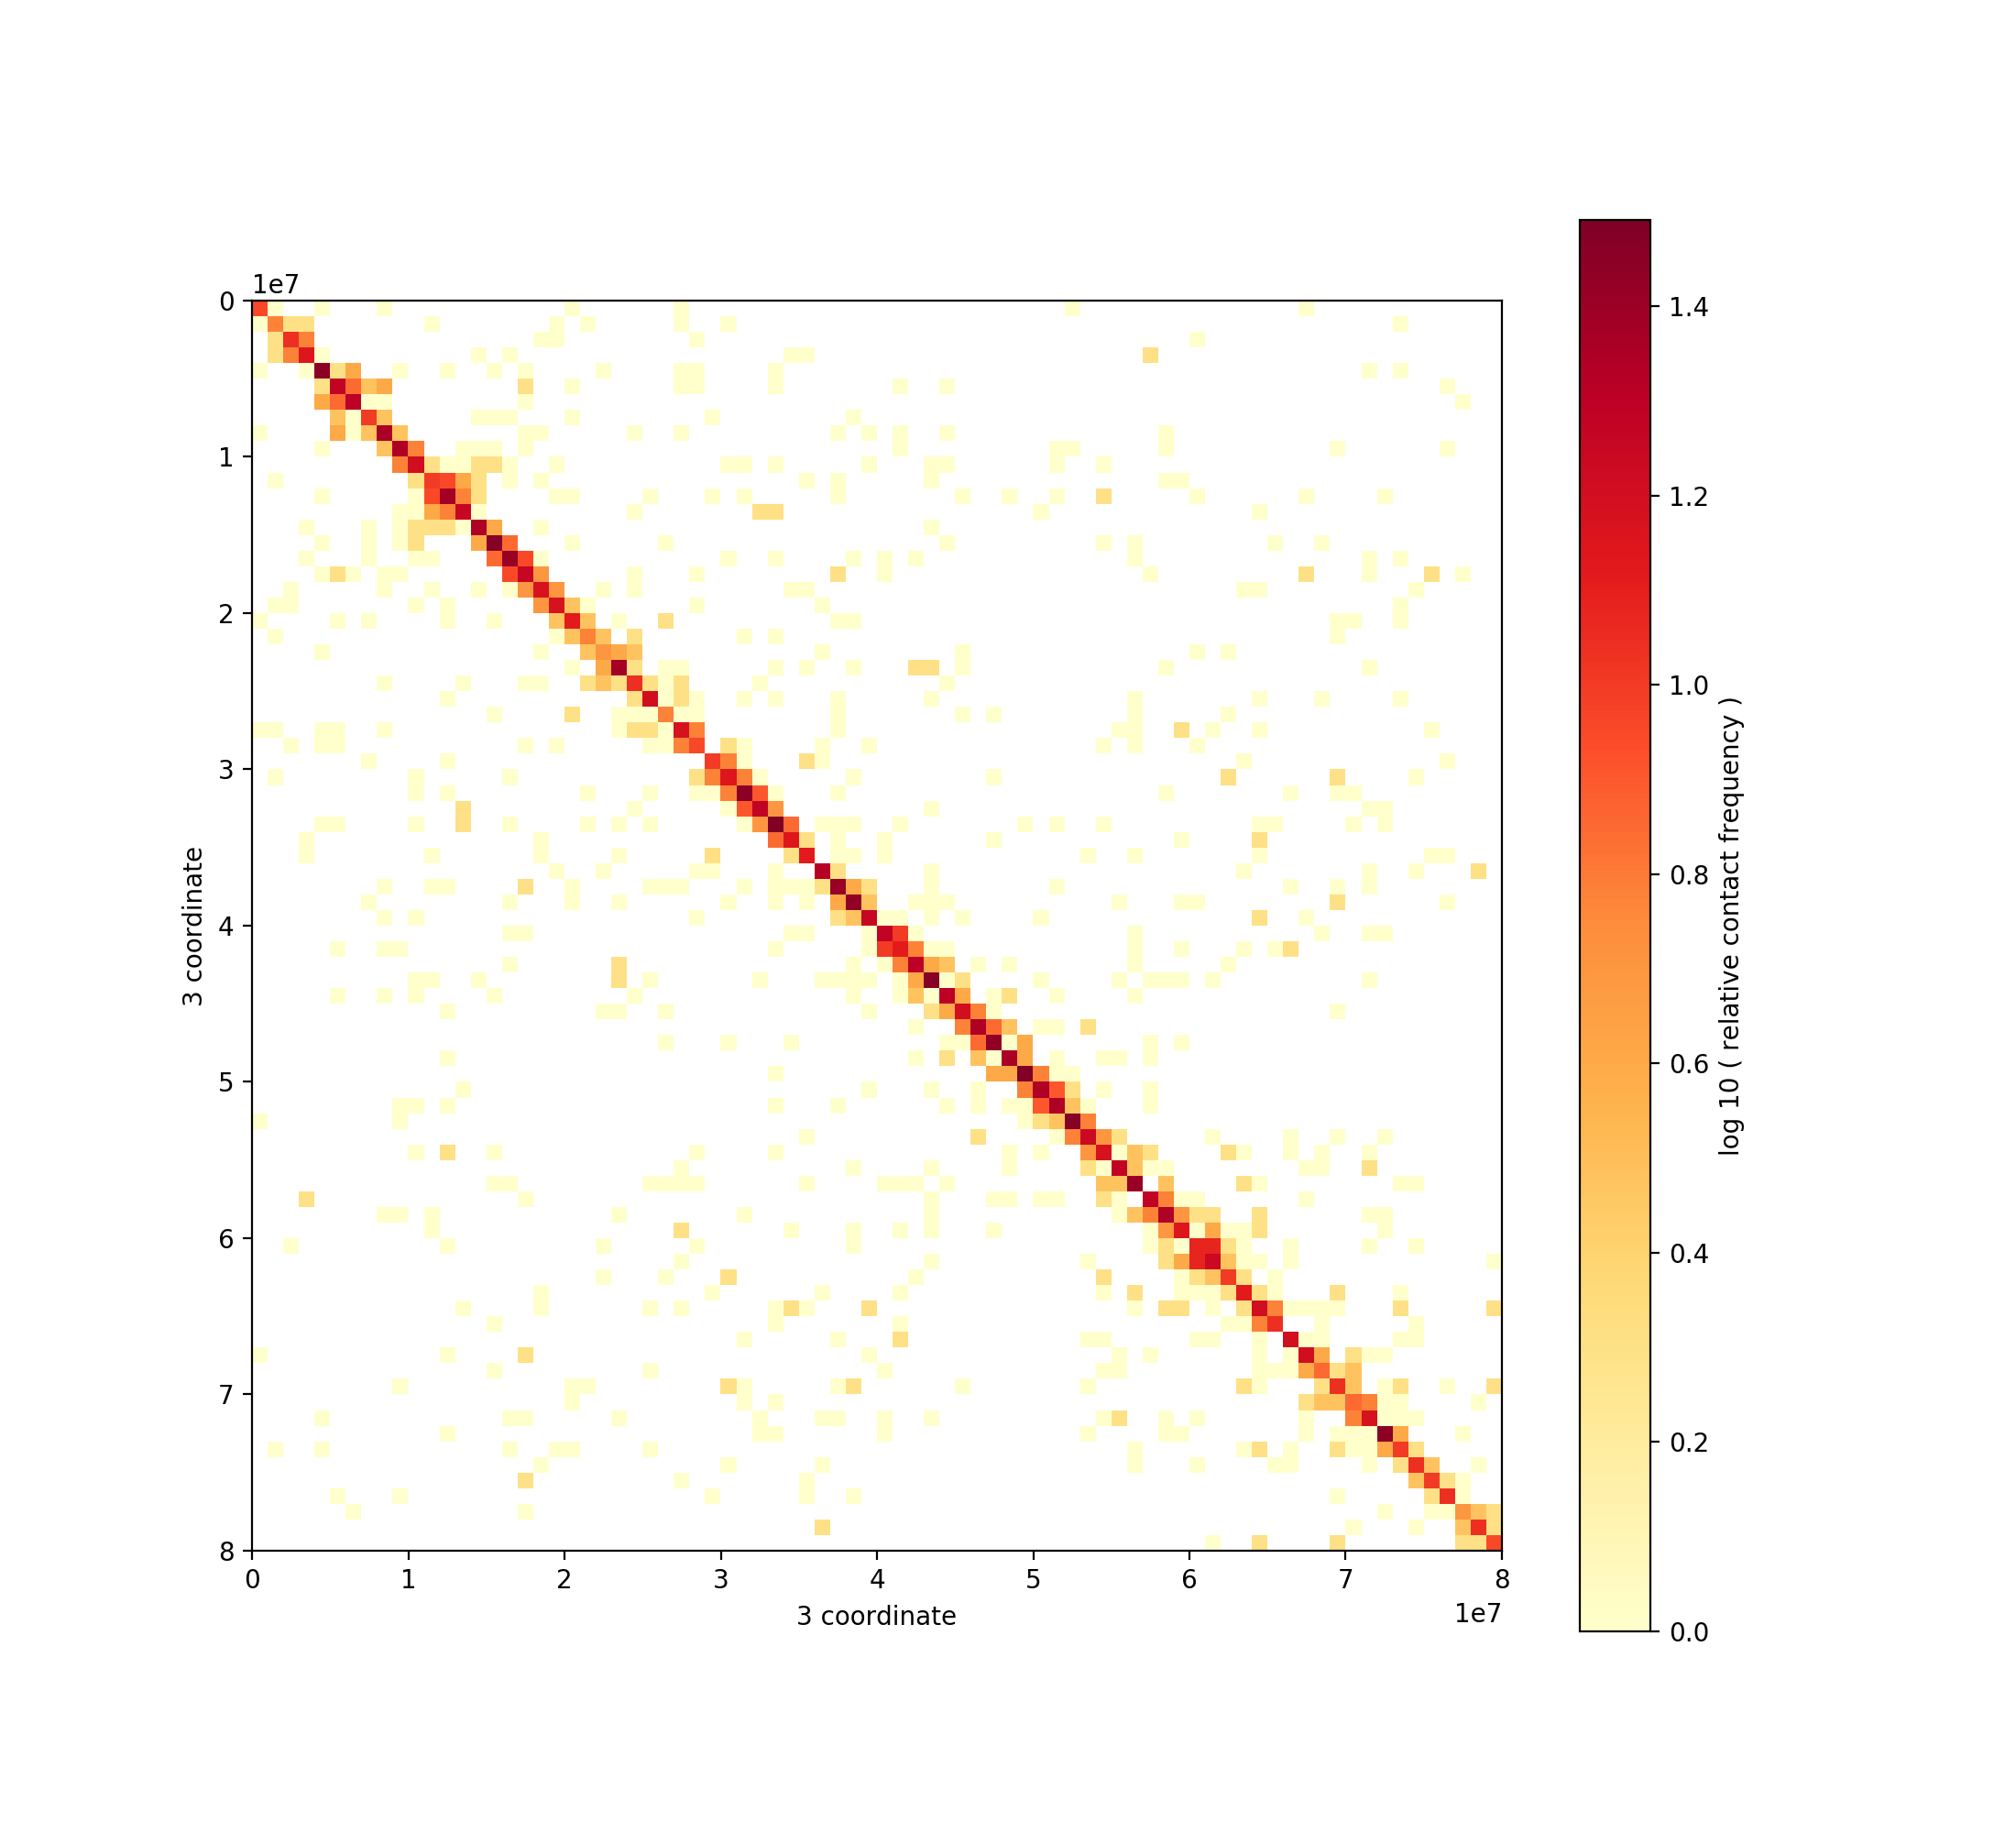

In [25]:
from IPython.display import Image
Image('test.png')

Here's what the full one looks like.

In [26]:
%%bash

cooler show --out test2.png --dpi 200 data/Rao2014-GM12878-MboI-allreps-filtered.1000kb.cool chr3:0-80,000,000

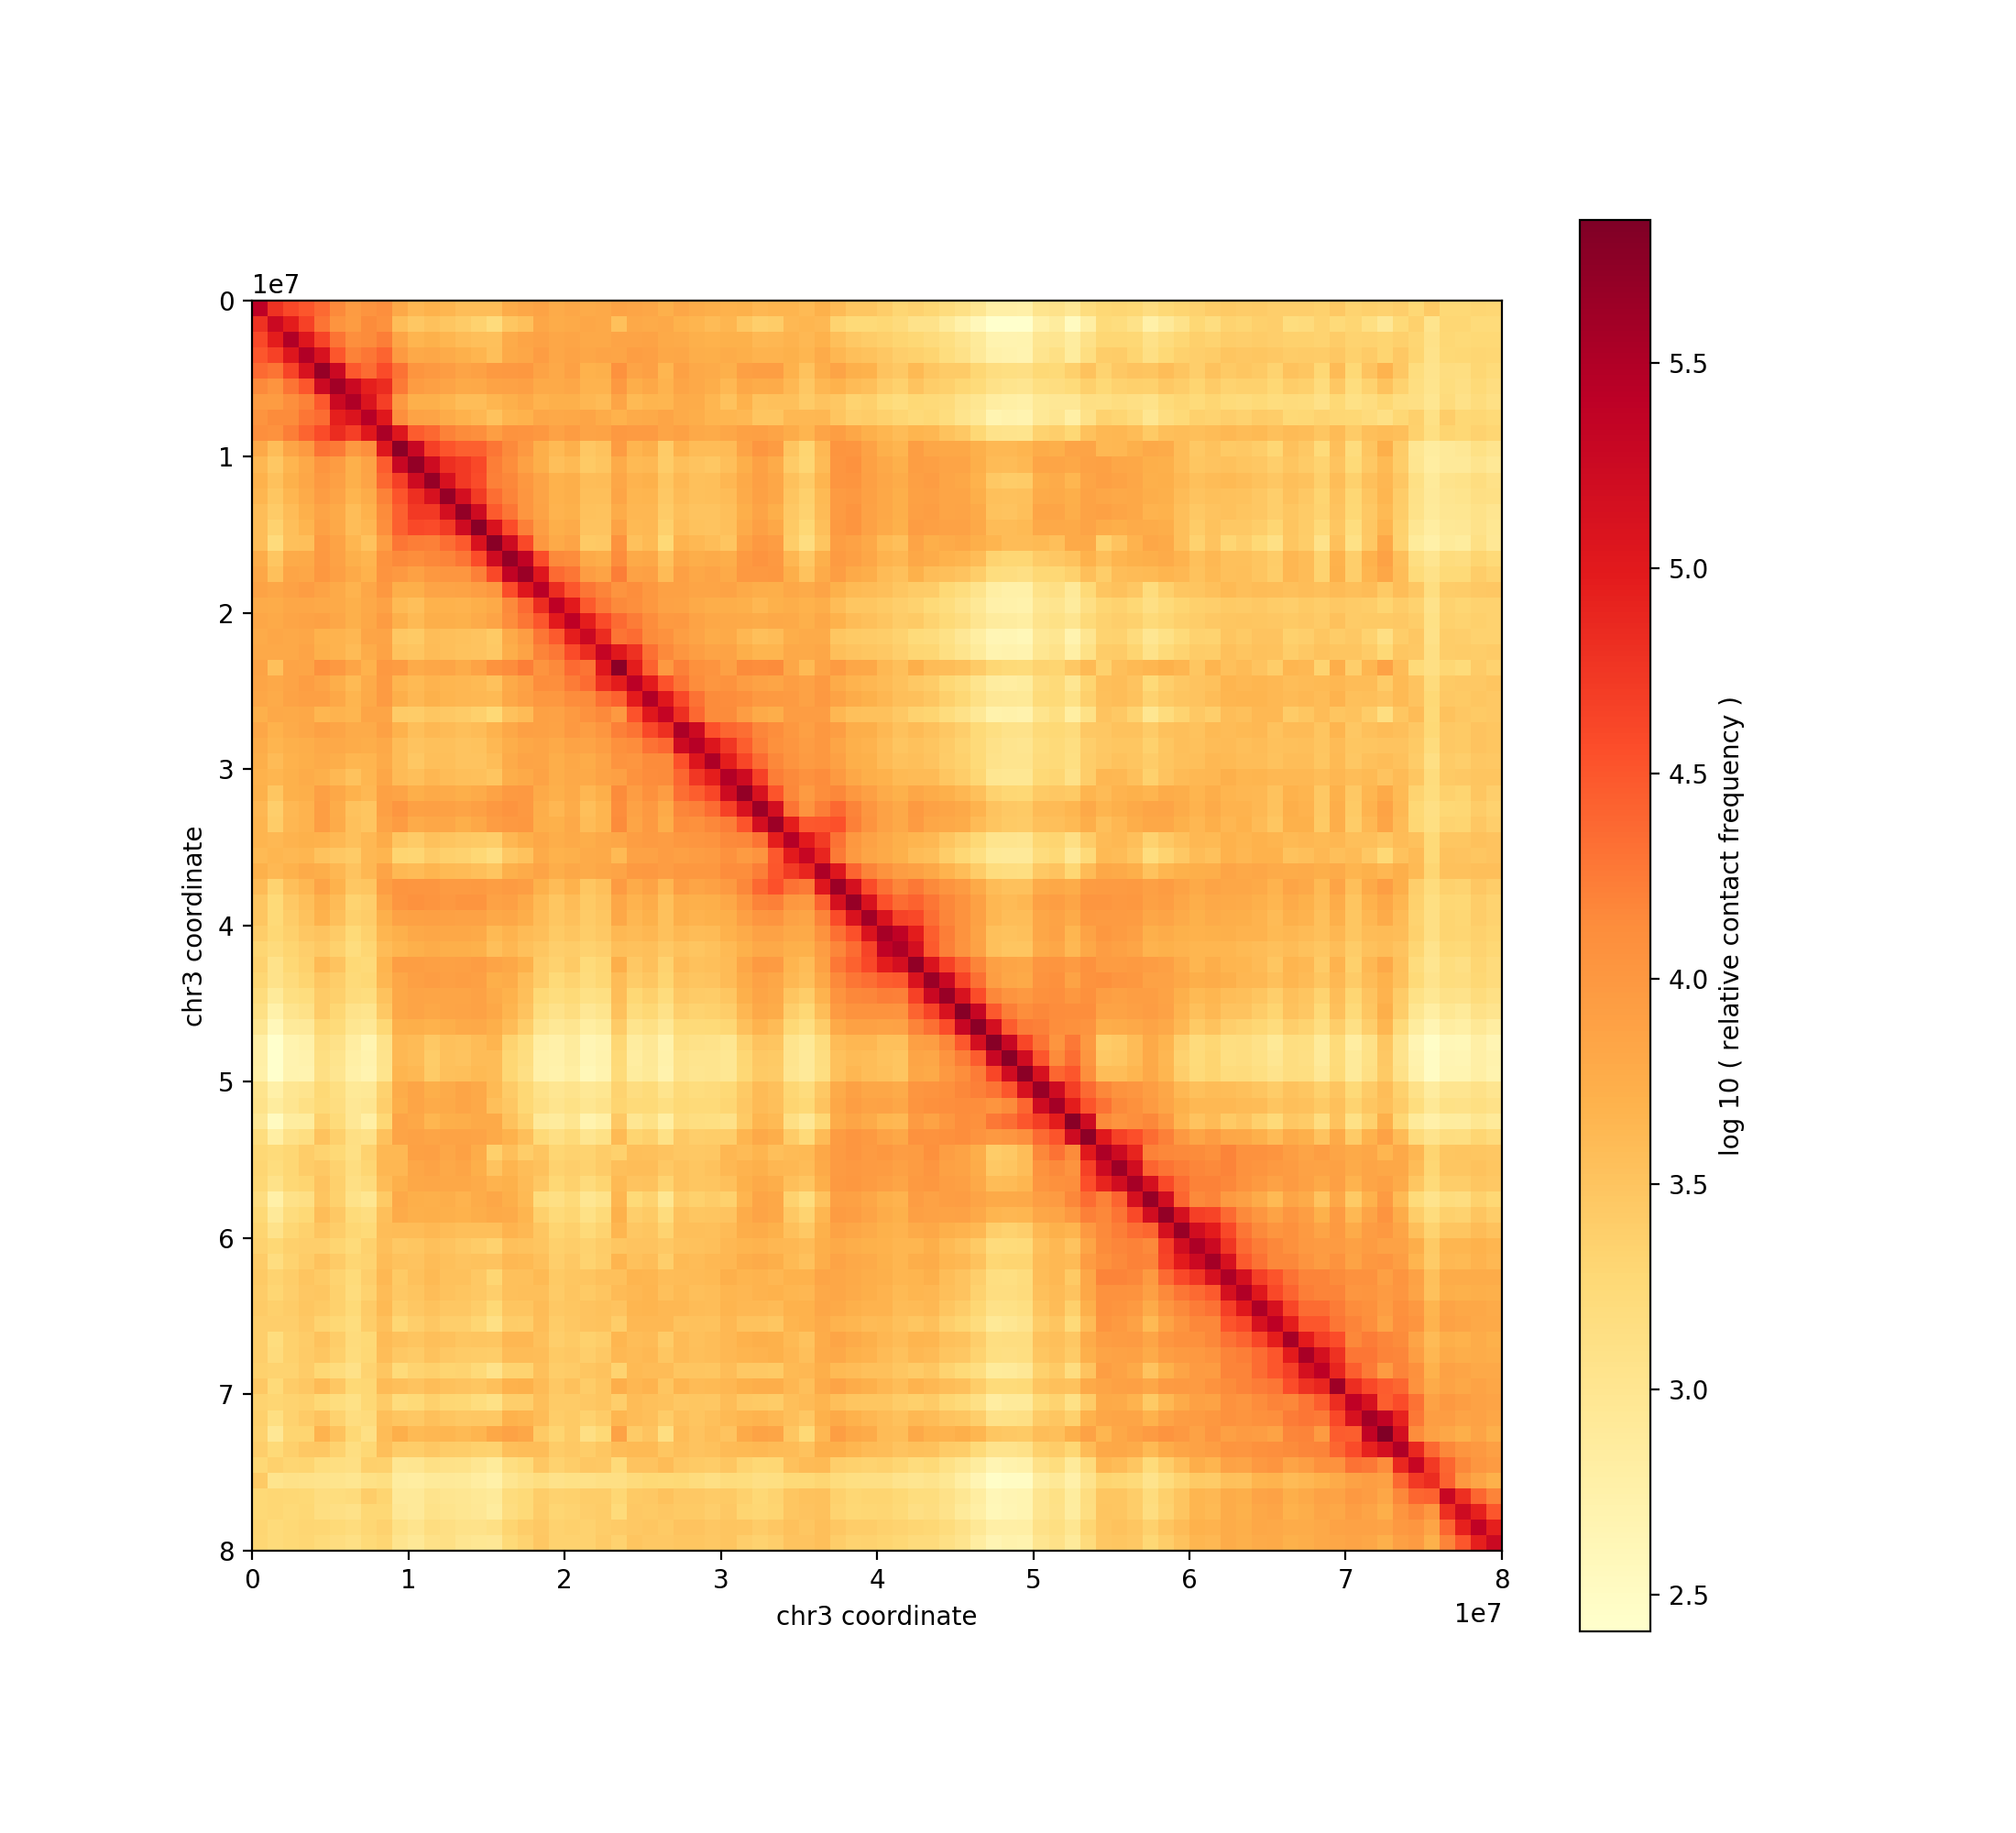

In [27]:
from IPython.display import Image
Image('test2.png')

## Optional: Load a pairs file indexed with [Pairix](https://github.com/4dn-dcic/pairix)

Alternatively, you can sort, format and index your pairs file before ingesting. Having an indexed pairs file can also be useful of other kinds of read-level analyses.

We use the `cooler csort` command to do this. What does it do? 

Given a chromosome order, it creates a new pairs file with the following properties:

1. _Consistently ordered mates_: mates of every interchromsomal pair are properly "flipped" in order to respect the requested order of the chromosomes. For intrachromosomal pairs, mates are flipped such that `pos1` is always less than or equal to `pos2`. As a result, the data will have an **upper triangular** orientation with respect to the chromosome order (interpreting sides 1 and 2 as `i` and `j` axes in a matrix coordinate system).
2. _Sorted_: once the mates are oriented, the pair records are lexically sorted by chrom1, chrom2, pos1, pos2. With (1) and (2), contacts are said to be sorted by chromosome-chromosome block, a.k.a. "block" sorted.
3. _Indexed_: we use [bgzip](http://www.htslib.org/doc/tabix.html) to compress the file and [Pairix](https://github.com/4dn-dcic/pairix) to index it. This creates a small `.px2` index file which facilitates 2-dimensional queries on the reads. 

**Notes**: 

- If (1) is already satisfied, you can also prepare a Pairix-indexed file manually, without `cooler csort`. See this [example](https://github.com/4dn-dcic/pairix#usage-examples-for-pairix)

In [28]:
!cooler csort -h

Usage: cooler csort [OPTIONS] PAIRS_PATH CHROMOSOMES_PATH

  Sort and index a contact list.

  Order the mates of each pair record so that all contacts are upper
  triangular with respect to the chromosome ordering given by the
  chromosomes file, sort contacts by genomic location, and index the
  resulting file.

  PAIRS_PATH : Contacts (i.e. read pairs) text file, optionally compressed.

  CHROMOSOMES_PATH : File listing desired chromosomes in the desired order.
  May be tab-delimited, e.g. a UCSC-style chromsizes file. Contacts mapping
  to other chromosomes will be discarded.

  **Notes**

  - csort can also be used to sort and index a text representation of
    a contact *matrix* in bedGraph-like format. In this case, substitute
    `pos1` and `pos2` with `start1` and `start2`, respectively.
  - Requires Unix tools: sort, bgzip + tabix or pairix.

  If indexing with Tabix, the output file will have the following
  properties:

  - Upper triangular: the read pairs on each row are a

In [29]:
%%bash
# Note that the input pairs file happens to be space-delimited, which we specify 
# with the --sep argument  (tab is assumed by default).
# The output pairs file will always be tab-delimited!

CHROMSIZES_FILE='data/b37.chrom.sizes'
PAIRS_FILE='data/GSM1551552_HIC003_merged_nodups.txt.subset.gz'

cooler csort -c1 3 -p1 4 -c2 7 -p2 8 --sep ' ' --out pairs.sorted.txt.gz $PAIRS_FILE $CHROMSIZES_FILE 

INFO:cooler.cli.csort:Enumerating requested chromosomes...
INFO:cooler.cli.csort:1	1
INFO:cooler.cli.csort:2	2
INFO:cooler.cli.csort:3	3
INFO:cooler.cli.csort:4	4
INFO:cooler.cli.csort:5	5
INFO:cooler.cli.csort:6	6
INFO:cooler.cli.csort:7	7
INFO:cooler.cli.csort:8	8
INFO:cooler.cli.csort:9	9
INFO:cooler.cli.csort:10	10
INFO:cooler.cli.csort:11	11
INFO:cooler.cli.csort:12	12
INFO:cooler.cli.csort:13	13
INFO:cooler.cli.csort:14	14
INFO:cooler.cli.csort:15	15
INFO:cooler.cli.csort:16	16
INFO:cooler.cli.csort:17	17
INFO:cooler.cli.csort:18	18
INFO:cooler.cli.csort:19	19
INFO:cooler.cli.csort:20	20
INFO:cooler.cli.csort:21	21
INFO:cooler.cli.csort:22	22
INFO:cooler.cli.csort:X	23
INFO:cooler.cli.csort:Y	24
INFO:cooler.cli.csort:MT	25
INFO:cooler.cli.csort:Input: 'data/GSM1551552_HIC003_merged_nodups.txt.subset.gz'
INFO:cooler.cli.csort:Output: 'pairs.sorted.txt.gz'
INFO:cooler.cli.csort:Reordering pair mates and sorting pair records...
INFO:cooler.cli.csort:Sort order: block (chrom1, chrom2

In [30]:
%%bash

# What's in the output?
zcat pairs.sorted.txt.gz | head

D260LACXX130602:2:2315:7361:72358	0	1	85378	186	16	1	591085	1097	0	0
D258GACXX130605:8:2316:2958:10584	0	1	719104	1418	16	1	728403	1406	20	10
C24LCACXX130513:8:2315:5697:82732	0	1	758309	1523	0	1	43498676	121266	68	120
D260LACXX130602:2:2209:16327:23744	0	1	784407	527093	16	1	229918735	1593	88	40
D260LACXX130602:2:2202:16754:100485	16	1	890311	1801	16	1	993887	2056	165	18
D260LACXX130602:2:2309:8547:48542	0	1	925938	1866	16	1	1034493	2117	178	60
C24LCACXX130513:8:2312:14225:27548	0	1	941657	1904	0	1	1620964	3551	178	0
D258GACXX130605:8:1201:10692:67155	0	1	949416	342780	16	1	155311666	1935	178	178
C24LCACXX130513:8:2307:2896:10307	0	1	951652	3944	16	1	1751062	1946	146	175
D258GACXX130605:8:2308:5276:50416	0	1	992230	2049	0	1	1255504	2556	175	178


Finally, using `cooler cload pairix`, we aggregate (bin) the contacts in `pairs.sorted.txt.gz` against the bins file, `bins.1000kb.bed`, and write the contents to the binary `test.cool` file.

A Pairix-indexed file has the advantage of 2D querying. However, it uses a slightly different sorting convention:

1. Like the previous Tabix scheme, interchromosomal pairs in Pairix files should consistently respect some order of the chromosomes (i.e. be "upper triangular"). Unlike the previous scheme, the chromosome order used to create the pairs file can be arbitrary, and does not need to match the order you wish to use in the cooler file.
2. Unlike the previous Tabix scheme, where the file is sorted by `chrom1`, `pos1`, `chrom2`, `pos2`, Pairix files are sorted by `chrom1`, `chrom2`, `pos1`, `pos2`. 


In [31]:
%%bash

cooler cload pairix -h

Usage: cooler cload pairix [OPTIONS] BINS PAIRS_PATH COOL_PATH

  Bin a pairix-indexed contact list file.

  BINS : One of the following

      <TEXT:INTEGER> : 1. Path to a chromsizes file, 2. Bin size in bp

      <TEXT> : Path to BED file defining the genomic bin segmentation.

  PAIRS_PATH : Path to contacts (i.e. read pairs) file.

  COOL_PATH : Output COOL file path or URI.

  See also: 'cooler csort' to sort and index a contact list file

  Pairix on GitHub: <https://github.com/4dn-dcic/pairix>.

Options:
  --metadata TEXT          Path to JSON file containing user metadata.
  --assembly TEXT          Name of genome assembly (e.g. hg19, mm10)
  -p, --nproc INTEGER      Number of processes to split the work between.
                           [default: 8]
  -0, --zero-based         Positions are zero-based  [default: False]
  -s, --max-split INTEGER  Divide the pairs from each chromosome into at most
                           this many chunks. Smaller chromosomes will be split
 

In [32]:
%%bash

# alternatively, we could pass $CHROMSIZES_FILE:1000000 below instead of creating $BINS_FILE
BINS_FILE='bins.1000kb.bed'
INDEXED_PAIRS_FILE='pairs.sorted.txt.gz'
OUTPUT_FILE='test.cool'

cooler cload pairix $BINS_FILE $INDEXED_PAIRS_FILE $OUTPUT_FILE

INFO:cooler.cli.cload:Using 8 cores
INFO:cooler.create:Creating cooler at "test.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Binning 1:0-125000000|*
INFO:cooler.create:Binning 1:125000000-249250621|*
INFO:cooler.create:Binning 2:0-129000000|*
INFO:cooler.create:Binning 2:129000000-243199373|*
INFO:cooler.create:Binning 3:0-158000000|*
INFO:cooler.create:Binning 3:158000000-198022430|*
INFO:cooler.create:Binning 4:0-163000000|*
INFO:cooler.create:Binning 4:163000000-191154276|*
INFO:cooler.create:Finished 4:163000000-191154276|*
INFO:cooler.create:Binning 5:0-173000000|*
INFO:cooler.create:Finished 3:158000000-198022430|*
INFO:cooler.create:Binning 5:173000000-180915260|*
INFO:cooler.create:Finished 5:173000000-180915260|*
INFO:cooler.create:Binning 6:0-171115067|*
INFO:cooler.create:Finished 1:125000000-249250621|*
INFO:cooler.create:Finished 2:129000000-243199373|*
INFO:cooler.create:Binning 7:0-1591386